## SKlearn NFM

#### Lets run SKLearn's NMF algorithm on a small 2d sample array

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

In [2]:
print("Input matrix of N x N w/ values (1-10)")
def generateV(N=25):
    return 10 * np.random.random_sample((N, N))
X = generateV()

Input matrix of N x N w/ values (1-10)


In [3]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize

V = generateV()

def my_nmf(input_df, n_components, learn_iter=200):
    input_matrix = input_df.to_numpy().T
    
#     print('Input Matrix Shape:\n', input_matrix.shape)
#     print('n comp:', n_components)
    
    activations = np.random.rand(n_components, input_matrix.shape[1])
#     np.random.rand(3,2)
    basis_vectors = np.random.rand(input_matrix.shape[0], n_components)
    ones = np.ones(input_matrix.shape)
    
    basis_vectors = normalize(basis_vectors)
    
#     print('Activations:\n', activations)
#     print('Basis Vectors:\n', basis_vectors)
#     print('Ones:\n', ones)
    
    for _ in range(learn_iter):
        activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
        basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
        
        # TODO - normalize basis vectors after each update
        basis_vectors = normalize(basis_vectors)
    
    
#     print('Activations:\n', activations)
#     print('Basis Vectors:\n', basis_vectors)

#     basis_vecs = pd.DataFrame(basis_vectors.T, columns=list(input_df.columns))
#     trans_vals = pd.DataFrame(activations.T, columns=[('PC' + str(i + 1)) for i in range(n_components)])
    
#     return basis_vecs, trans_vals
    return basis_vectors.T, activations.T

In [7]:
def correlate(nmf_i, pca_i):
    return pearsonr(nmf_i, pca_i)[0]

In [51]:
N = X.shape[1]
err_outs = []
sk_errs = []
my_errs = []

for i in range(N - 1, 2, -1): # inclusive range to N
    skl_nmf = NMF(n_components=i, init='random', solver='mu', beta_loss='kullback-leibler')
    sh = skl_nmf.fit_transform(X)
    sw = skl_nmf.components_
    sv = np.matmul(sw.transpose(), sh.transpose())
    
    mw, mh = my_nmf(pd.DataFrame(X), i)
    mv = np.matmul(mw.transpose(), mh.transpose())
    err_corr = 0
    err_my = 0
    err_sk = 0
    cnt = 0.0
    for k in range(len(mv[0])):
        err_sk += mean_squared_error(sv[k], X[k])
        err_my += mean_squared_error(mv[k], X[k])
        err_corr += correlate(mv[k], sv[k])
        cnt += 1
    err_outs.append(err_corr / cnt)
    sk_errs.append(err_sk / cnt)
    my_errs.append(err_my / cnt)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf

#### Here is our mean_squared_error for modifying n_components in SKLearn's NMF Algorithm

,0
count,22.000000
mean,0.882164
std,0.079463
min,0.712701
25%,0.835847
50%,0.899496
75%,0.950308
max,0.984635


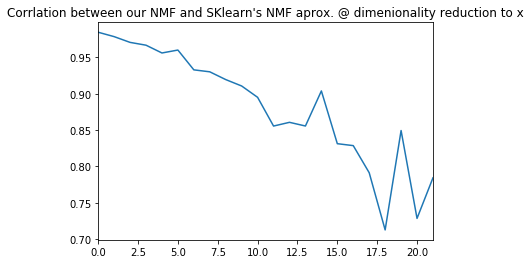

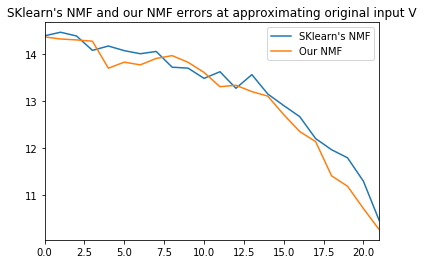

In [52]:
errs_total = pd.DataFrame([sk_errs, my_errs]).transpose()
errs_total.columns = ['SKlearn\'s NMF', 'Our NMF']
display(pd.DataFrame(err_outs).describe())
pd.Series(err_outs).plot(title="Corrlation between our NMF and SKlearn's NMF aprox. @ dimenionality reduction to x")
errs_total.plot(title="SKlearn's NMF and our NMF errors at approximating original input V")

In [33]:
av = generateV()
w, h = my_nmf(pd.DataFrame(av), 2)
nv = np.matmul(w.transpose(),h.transpose())
print("Shape of actual V is {}".format(av.shape))
print("Shape of new V is {}".format(nv.shape))

Shape of actual V is (25, 25)
Shape of new V is (25, 25)


# Testing Accuracy with NMF:

## Comparing to PCA

<img src="screenshots/compare_pca.jpg" alt="Drawing" style="width: 1000px;"/>

We need some way to compare nmf and pca at dimensions higher when reducing to dimensions higher than two. One way to do this is to use a pearson correlation test between pairs of basis vectors from NMF and PCA respectively.  

Below highlights the usgage of scipys pearsonr function which we use to calculate Pearson's correlation coefficient from our nmf and pca basis vectors.

In [ ]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [2,4,6,8,10,12,14,16,18,20]
print("Pearson's correlation coefficient = {}".format(((pearsonr(x,y)[0] + pearsonr(y,x) )/ 2)[0]))

Averaging all possible pairs Pearson correlation coefficient

In [ ]:
display(PCA(n_components=2).fit_transform(V).transpose())

In [ ]:
# TODO need NMF model function
def compareNMFtoPCA(V):
    Vn = np.array(V)
    F = len(V[0]) # feature count
    pair_matrices = []
    df = []
    for i in range(F,1,-1):
        # p = PCA(n_components=i).fit_transform(Vn).transpose()
        p = PCA(n_components=i).fit(Vn).components_
        pairs = [[0]*i]*i 
        w, h = my_nmf(pd.DataFrame(V), i)
        # w = w
        sum = 0.0        
        for nmf_i in range(i):
            for pca_i in range(i):
                sum += correlate(w[nmf_i], p[pca_i])
                # print("{}".format(correlate(h[nmf_i], p[pca_i])))
                pairs[nmf_i][pca_i] = correlate(w[nmf_i], p[pca_i])
        # print ("Total AVG Correlation @{} = {}".format(i, (sum / cnt)))
        df.append([(sum / i)])
        pair_matrices.append(pairs)
            
    return pd.DataFrame(df, columns=["Correlation"]), pair_matrices
        
l_p_vals = compareNMFtoPCA(V) # outputs list of pair matrices containing pearson correlation values for each [ith dimension][nmf_ith basis vector][pca_ith basis vector]
# need to run analysis on above. maybe avg pair correlation values at each iteration?

In [ ]:
display(l_p_vals[0].plot())

## Recursive NMF Dimensionality Reduction? 
Do we lose more info in aproximating each step or losing the dimensions?

In [ ]:
def recur_reduce_nmf(V, target, n=2):
    w, h = my_nmf(pd.DataFrame(V), target - 1)
    if(target == n + 1):
        return w, h
    return recur_reduce_nmf(np.dot(w, h), target - 1)

In [ ]:
test_v = generateV()
wt, ht = my_nmf(pd.DataFrame(test_v), 2)
wr, hr = recur_reduce_nmf(test_v, len(test_v) - 1)

tV = np.dot(wt, ht)
rV = np.dot(wr, hr)

In [ ]:
pd.DataFrame(wr).plot()
pd.DataFrame(wt).plot()
pd.DataFrame(hr).plot()
pd.DataFrame(ht).plot()

pd.DataFrame(rV).plot()
pd.DataFrame(tV).plot()

# Clustering our PCA and NMF transformed V